In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patches as mpatches
import matplotlib.cbook as cbook

In [2]:
import numpy as np 
import pandas as pd 
import geopandas as gpd
from epiweeks import Week
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mosqlient.models.score import Scorer
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from utils import load_preds, COLOR_MAP, UNIQUE_MODELS
import seaborn as sns
import matplotlib as mpl
# Definir a cor das bordas (spines) como cinza
mpl.rcParams['axes.edgecolor'] = 'gray'

# Definir a cor das linhas dos ticks maiores e menores como cinza
mpl.rcParams['xtick.color'] = 'gray'
mpl.rcParams['ytick.color'] = 'gray'
mpl.rcParams['xtick.labelcolor'] = 'black'
mpl.rcParams['ytick.labelcolor'] = 'black'

In [3]:
dates_23 = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 39).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

dates_24 = pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2024, 23).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

dates_25 = pd.date_range(start= Week(2024, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2025, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

data_all = pd.read_csv('../data/dengue_uf.csv.gz')
data_all.date = pd.to_datetime(data_all.date)


In [4]:
states_ne = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'SE', 'RN']
states_se = ['SP', 'RJ', 'ES', 'MG']
states_sul = ['RS', 'SC', 'PR' ]
states_ce = ['DF', 'MT', 'MS', 'GO']
states_no = ['AP', 'TO', 'RR', 'RO', 'AM' ,'AC', 'PA']

states_BR = states_ne+states_se+states_no+states_ce+states_sul

get the predictions from the separated models: 

In [5]:
df_preds_all,  models_by_state, data_all = load_preds(exclude = False)

df_preds_all.head()

,date,pred,lower,upper,state,model_id
0,2022-10-09,110.690113,64.291013,219.826948,AC,A
1,2022-10-16,144.952846,77.564037,279.722708,AC,A
2,2022-10-23,163.613937,92.915072,276.591399,AC,A
3,2022-10-30,170.240443,87.197631,378.407811,AC,A
4,2022-11-06,215.117888,111.835667,445.024983,AC,A


In [6]:
def rank_models(data_all, df_preds_all, dates): 

    df_bm = pd.DataFrame()

    for state in states_BR: 
    
        df_casos = data_all.loc[(data_all.uf == state) & data_all.date.isin(dates)]
        
        preds = df_preds_all.loc[(df_preds_all.state == state) & df_preds_all.date.isin(dates)]
        
        scores = {} 
    
        for model in preds.model_id:
            
            score = Scorer(df_casos, 
                           pred = preds.loc[preds.model_id == model], confidence_level=0.9)
        
            scores[model] = {'mse':score.mse['pred'], 
                                  'interval_score':score.interval_score[1]['pred']}
     
        df_ = pd.DataFrame(pd.DataFrame(scores).idxmin(axis=1), columns = ['best_model'])
    
        df_['state'] = state
    
        df_bm = pd.concat([df_bm, df_])
    
    return df_bm

In [7]:
df_bm_23 = rank_models(data_all, df_preds_all, dates=dates_23)

df_bm_23.head()

,best_model,state
mse,F,AL
interval_score,B,AL
mse,ln_crps,BA
interval_score,ln_log,BA
mse,lin_log,CE


In [8]:
df_bm_24 = rank_models(data_all, df_preds_all, dates=dates_24)

df_bm_24.head()

,best_model,state
mse,E,AL
interval_score,ln_base,AL
mse,E,BA
interval_score,E,BA
mse,lin_crps,CE


### Compute the skill score: 

In [9]:
def rank_ss_models(data_all, df_preds_all, dates): 

    df_bm = pd.DataFrame()

    scores_state = {}
    for state in states_BR: 
    
        df_casos = data_all.loc[(data_all.uf == state) & data_all.date.isin(dates)]
        
        preds = df_preds_all.loc[(df_preds_all.state == state) & df_preds_all.date.isin(dates)]
    
        scores = {} 
    
        for model in preds.model_id:
            
            score = Scorer(df_casos, 
                           pred = preds.loc[preds.model_id == model], confidence_level=0.9)
        
            scores[model] = {'mse':score.mse['pred'], 
                                  'interval_score':score.interval_score[1]['pred']}
    
        scores_state[state] = scores
        
    return scores_state

In [10]:
def get_ss_list(sc_m, state, metric = 'mse'): 
    
    error_metrics = pd.DataFrame(sc_m[state]).T

    best_metric = error_metrics.sort_values(by = metric).index[0]
    metric_best_model = error_metrics.sort_values(by = metric )[metric].values[0]#[0]


    metric_ss = []
    for model in error_metrics.index:
        if model != best_metric: 
            metric_ss.append(1- (metric_best_model/error_metrics.loc[model][metric])   )
    
    return metric_ss

In [11]:
def get_ss_best_models(sc_m, state, metric = 'mse'): 
    
    error_metrics = pd.DataFrame(sc_m[state]).T

    best_model = error_metrics.sort_values(by = metric).index[0]
    metric_best_model = error_metrics.sort_values(by = metric )[metric].values[0]

    metric_second_model = error_metrics.sort_values(by = metric )[metric].values[1]
    
    return best_model, 1- (metric_best_model/metric_second_model)

In [12]:
def get_df_ss_best_models(sc_m): 
    df_ss_best_models_mse = pd.DataFrame()
    df_ss_best_models_int = pd.DataFrame()
    
    for state in sc_m.keys():
    
        df_ss_mse = pd.DataFrame()
        df_ss_int = pd.DataFrame()
    
        model_name_mse, ss_mse = get_ss_best_models(sc_m, state, metric = 'mse')
    
        model_name_int, ss_int = get_ss_best_models(sc_m, state, metric = 'interval_score')
    
        df_ss_mse['model'] = [model_name_mse]
        df_ss_mse['ss'] = [ss_mse]
    
        df_ss_int['model'] = [model_name_int]
        df_ss_int['ss'] = [ss_int]
        
        df_ss_best_models_mse = pd.concat([df_ss_best_models_mse, df_ss_mse], ignore_index = True)
        df_ss_best_models_int = pd.concat([df_ss_best_models_int, df_ss_int], ignore_index = True)

    return df_ss_best_models_mse, df_ss_best_models_int
    

In [13]:
sc_m_23 = rank_ss_models(data_all, df_preds_all, dates=dates_23)
sc_m_24 = rank_ss_models(data_all, df_preds_all, dates=dates_24)

df_ss_mse_23, df_ss_int_23 = get_df_ss_best_models(sc_m_23)
df_ss_mse_24, df_ss_int_24 = get_df_ss_best_models(sc_m_24)

for df in [df_ss_mse_23, df_ss_mse_24, df_ss_int_23, df_ss_int_24]: 

    df['model'] = df['model'].astype(str)

### Mapas:

In [14]:
brazilian_states_upper = {
    "ACRE": "AC",
    "ALAGOAS": "AL",
    "AMAPA": "AP",
    "AMAZONAS": "AM",
    "BAHIA": "BA",
    "CEARA": "CE",
    "DISTRITO FEDERAL": "DF",
    "ESPIRITO SANTO": "ES",
    "GOIAS": "GO",
    "MARANHAO": "MA",
    "MATO GROSSO": "MT",
    "MATO GROSSO DO SUL": "MS",
    "MINAS GERAIS": "MG",
    "PARA": "PA",
    "PARAIBA": "PB",
    "PARANA": "PR",
    "PERNAMBUCO": "PE",
    "PIAUI": "PI",
    "RIO DE JANEIRO": "RJ",
    "RIO GRANDE DO NORTE": "RN",
    "RIO GRANDE DO SUL": "RS",
    "RONDONIA": "RO",
    "RORAIMA": "RR",
    "SANTA CATARINA": "SC",
    "SAO PAULO": "SP",
    "SERGIPE": "SE",
    "TOCANTINS": "TO",
}


In [15]:
df_gpd = gpd.read_file('states.shp', columns = ['ADM1_NAME', 'geometry'])

df_gpd['state'] = df_gpd['ADM1_NAME'].replace(brazilian_states_upper)

df_gpd.head()

,ADM1_NAME,geometry,state
0,ACRE,"POLYGON ((-66.8097 -9.81766, -66.62442 -9.8987...",AC
1,ALAGOAS,"POLYGON ((-35.1492 -8.91435, -35.16193 -8.9508...",AL
2,AMAPA,"MULTIPOLYGON (((-50.00722 0.88168, -50.04045 0...",AP
3,AMAZONAS,"POLYGON ((-58.89492 0.26385, -58.89449 -0.0106...",AM
4,BAHIA,"MULTIPOLYGON (((-38.91168 -13.67529, -38.94611...",BA


### Formulando o boxplot do skill score:

In [16]:
def add_n_samples(ax_bar1, df_ss, fil_order):
    # Calculate the data for each category and its stats
    grouped_data = df_ss.groupby('model')['ss']
    box_stats = cbook.boxplot_stats([grouped_data.get_group(cat).tolist() for cat in fil_order])
    
    # Annotate each boxplot with the sample count above the upper whisker
    for i, (cat, stats) in enumerate(zip(fil_order, box_stats)):
        max_whisker = stats['whishi']  # Upper whisker value
        count = len(grouped_data.get_group(cat))  # Number of samples in this category
        ax_bar1.text(i, max_whisker+0.01, f'(n={count})', 
                ha='center', va='bottom', fontsize=10, color='black')
    
    ax_bar1.set_ylim([df_ss.ss.min(), df_ss.ss.max() + 0.1])

    ax_bar1.grid(axis ='y')
    

In [17]:
def make_map_ss(df_gpd, df_bm, df_ss_mse, df_ss_int, year):
    df_gpd = df_gpd.merge(df_bm.reset_index(), left_on = 'state', right_on = 'state')

    fil_order_mse = [model for model in UNIQUE_MODELS if model in df_ss_mse['model'].unique()]
    fil_order_int = [model for model in UNIQUE_MODELS if model in df_ss_int['model'].unique()]

    region_column = 'best_model'
    
    # Create a figure
    fig = plt.figure(figsize=(13, 8.25))
    
    # Create a GridSpec with 2 rows and 2 columns
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], figure=fig)
    
    # First Line 
    df_ = df_gpd.loc[df_gpd['index'] == 'mse']
    df_[region_column] = df_[region_column].astype(str)
    
    cat_mse = sorted(df_[region_column].unique())
    
    df_['color'] = df_[region_column].map(COLOR_MAP)
    
    # Manually add a legend
    patches_mse = [mpatches.Patch(color=COLOR_MAP[cat], label=cat) for cat in cat_mse]
    
    # Map subplot (top-left)
    ax_map1 = fig.add_subplot(gs[0, 0])
    df_.plot(color=df_['color'], ax=ax_map1, edgecolor = 'black')
    ax_map1.axis('off')
    ax_map1.legend(title = 'Best model', handles=patches_mse, bbox_to_anchor = (1.25, 0.9))
    
    # Bar plot subplot (top-right)
    
    ax_bar1 = fig.add_subplot(gs[0, 1])
    sns.boxplot(x='model', y='ss', data = df_ss_mse, ax=ax_bar1, order = fil_order_mse, palette=COLOR_MAP)
    ax_bar1.set_title('SS between the best-performing\n model and the second-best (MSE)')

    add_n_samples(ax_bar1, df_ss_mse, fil_order_mse)
    
    df_ = df_gpd.loc[df_gpd['index'] == 'interval_score']
    df_[region_column] = df_[region_column].astype(str)
    
    cat_interval = sorted(df_[region_column].unique())
    
    # Map colors to each row in the GeoDataFrame
    df_['color'] = df_[region_column].map(COLOR_MAP)

    patches_int = [mpatches.Patch(color=COLOR_MAP[cat], label=cat) for cat in cat_interval]
    
    # Map subplot (bottom-left)
    ax_map2 = fig.add_subplot(gs[1, 0])
    df_.plot(color=df_['color'], ax=ax_map2, edgecolor = 'black')
    ax_map2.axis('off')
    ax_map2.legend(title = 'Best model', handles=patches_int, bbox_to_anchor = (1.25, 0.9))
    
    # Bar plot subplot (bottom-right)
    ax_bar2 = fig.add_subplot(gs[1, 1])
    sns.boxplot(x='model', y='ss', data = df_ss_int, ax=ax_bar2, order = fil_order_int, palette=COLOR_MAP)
    ax_bar2.set_title('SS between the best-performing\n model and the second-best (Interval Score)')
    #ax[0].legend(loc= 'upper left')
    # Adjust layout
    
    add_n_samples(ax_bar2, df_ss_int, fil_order_int)
    plt.tight_layout()
    # Manually shrink the height of bar plots
    for ax in [ax_bar1, ax_bar2]:
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width, box.height * 0.7])  # Reduce height by 30%
        for label in ax.get_xticklabels():
            label.set_rotation(30)
    
    # Shift the plots in the first column slightly to the left
    for ax in [ax_bar1, ax_bar2]:
        ax.set_ylabel('Skill Score (SS)')
        box = ax.get_position()
        ax.set_position([box.x0 - 0.075, box.y0 +0.05, box.width, box.height])  # Shift left by 0.05

    ax_bar1.set_xlabel('')
    
    for ax in [ax_map2, ax_bar2]:
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 +0.1, box.width, box.height])  # Shift left by 0.05
    
    plt.suptitle(year, x = 0.56, y=0.95, fontsize = 14)
    # Show the combined plot
    #plt.subplots_adjust(hspace = 0.05)

    plt.savefig(f'../figures/map_ss_{year}.pdf', bbox_inches = 'tight')
    plt.show()

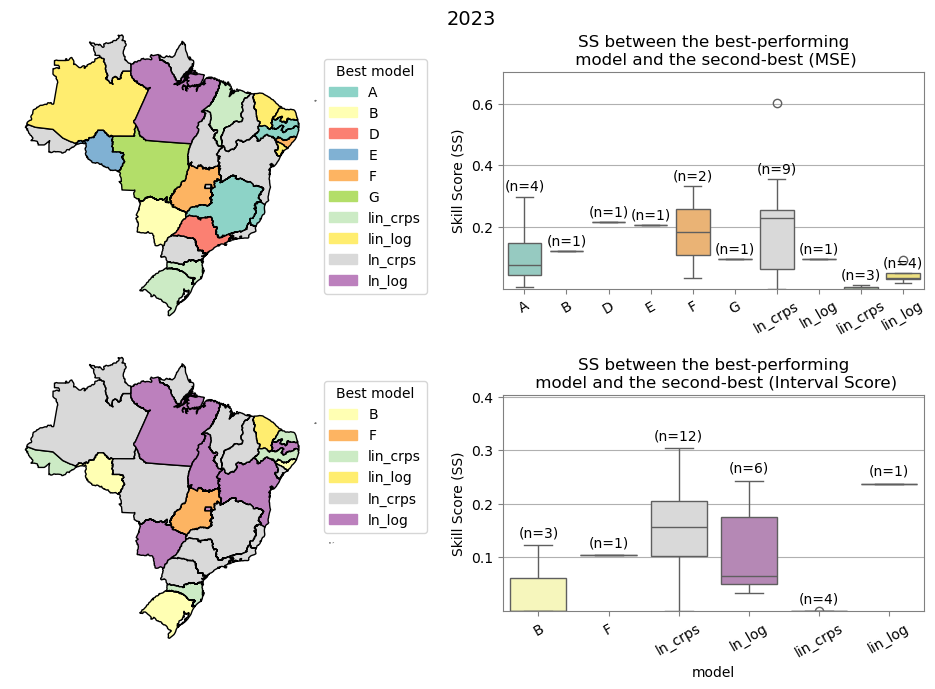

In [18]:
make_map_ss(df_gpd, df_bm_23, df_ss_mse_23, df_ss_int_23, year = 2023)

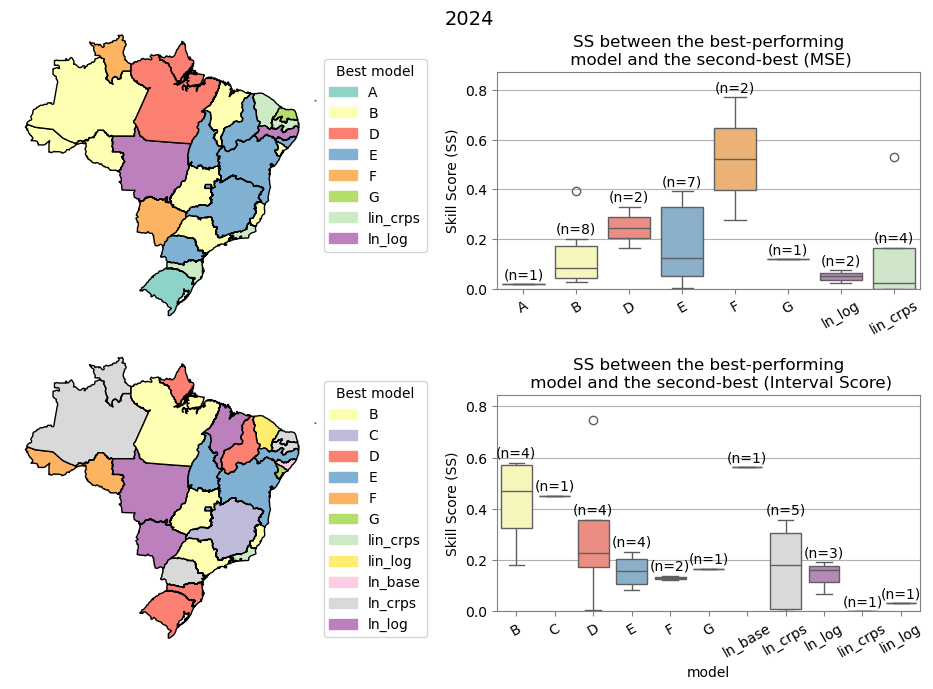

In [19]:
make_map_ss(df_gpd, df_bm_24, df_ss_mse_24, df_ss_int_24, year = 2024)